## Configure tesseract

In [111]:
import pytesseract
print(pytesseract.get_tesseract_version())
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

5.5.0.20241111


## โหลดรูปเบื้องต้น

In [118]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_V6_TN")
output_folder.mkdir(exist_ok=True)

image = cv2.imread("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_5.png")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

denoised = cv2.bilateralFilter(image, d=9, sigmaColor=100, sigmaSpace=100) # จำกัด noise
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

binary_gaussian = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=51, 
    C=21
)

cv2.imwrite(f"{output_folder}/original.png", image)
cv2.imwrite(f"{output_folder}/denoised.png", denoised)
cv2.imwrite(f"{output_folder}/gray.png", gray_img)
cv2.imwrite(f"{output_folder}/binary_g.png", binary_gaussian)


True

## แยกตารางเกรดกับข้อมูลนักศึกษา

In [125]:
def split_grade_table_and_students(binary_img, denoised):
    
    # แยกตาราง
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
    areas = [stat[4] for stat in stats]  # ดึงค่า area
    sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
    second_max_area = sorted_areas[1]  # ค่าอันดับ 2
    second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม
    table_position = stats[second_max_area_index]
    x, y, w, h, area = table_position
    table_img = binary_img[y:y+h, x:x+w]
    table_original_img = denoised[y:y+h, x:x+w]

    # ข้อมูลนักเรียน
    #x_start = int((x+w) * 0.40) # ความกว้าง 40% ของตาราง
    x_end = int((x+w) * 0.85) # ความกว้าง 85% ของตาราง
    x_split_half = int((x+w) * 0.38) # ความกว้าง 38% ของตาราง

    student_info_img = binary_img[:y, :x_end]
    student_info_fh_img = binary_img[:y, :x_split_half] # ครึ่งแรก
    student_info_sh_img = binary_img[:y, x_split_half:x_end] # ครึ่งหลัง

    return table_img, student_info_img, student_info_fh_img, student_info_sh_img, table_original_img

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        #print(area)
        if area > 1000:
            #print("มา")
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area

    return biggest

def persective_transformation(table_binary_img, table_original_img):

    # ค้นหาคอนทัวร์
    contours, hierarchy = cv2.findContours(table_binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # ค้นหาสี่เหลี่ยมที่ใหญ่ที่สุด
    biggest = biggest_contour(contours)

    points = biggest.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points

    # Euclidean Distance Formula
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    rigth_height = np.sqrt(((top_left[0] - bottom_right[0]) ** 2) + ((top_left[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    # Output image size
    #max_width = max(int(bottom_width), int(top_width))
    expand_width = round(max(int(bottom_width), int(top_width)) * 0.4)
    max_width = max(int(bottom_width), int(top_width)) + expand_width
    max_height = max(int(rigth_height), int(left_height))

    # Desird points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformaxtion
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_out = cv2.warpPerspective(table_binary_img.copy(), matrix, (max_width, max_height))
    img_original_out = cv2.warpPerspective(table_original_img.copy(), matrix, (max_width, max_height))

    return img_out, img_original_out

def hough_line_transform(binary_image, table_original_persective_img):

    # 1) ใช้ HoughLinesP ตรวจจับเส้น
    #    - พารามิเตอร์ที่สำคัญ: threshold, minLineLength, maxLineGap
    lines = cv2.HoughLinesP(
        binary_image,
        rho=1,
        theta=np.pi/180,
        threshold=100,      # ต้องปรับจูน
        minLineLength=600,  # ต้องปรับจูน
        maxLineGap=10     # ต้องปรับจูน
    )

    # 2) สร้าง mask (เป็นภาพดำล้วน ขนาดเท่ากับต้นฉบับ)
    line_mask = np.zeros_like(binary_image)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # วาดเส้นสีขาวลงใน mask (ปรับ thickness ตามความหนาเส้นในภาพ)
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)

    # 4) เราจะเอา mask นี้มาช่วยลบเส้นในภาพ
    #    วิธีง่าย ๆ คือการเอา thresh ที่เป็น binary_inv มาลบด้วย mask (bitwise)
    #    หรืออาจใช้เทคนิค inpaint บนภาพสี

    # วิธีที่ 4.1: ลบตรง ๆ จาก thresh ก่อน (ซึ่งเป็น Binary แล้ว)
    table_without_lines = cv2.bitwise_and(binary_image, cv2.bitwise_not(line_mask))


    # หรือ วิธีที่ 4.2: ลอง inpaint บนภาพจริงสี (img)
    #    โดยปกติ inpaint จะต้องการ mask สีขาว บริเวณที่ต้องการซ่อมแซม
    #    ซึ่ง line_mask ของเราพอดีอยู่แล้ว
    inpainted = cv2.inpaint(table_original_persective_img, line_mask, 3, cv2.INPAINT_TELEA)

    #kernel = np.ones((20, 15), np.uint8)
    #final_dilate = cv2.dilate(image_without_lines, kernel, iterations=1)


    # เนื่องจาก thresh เป็น invert (พื้นดำ ตัวหนังสือขาว)
    # ถ้าอยากกลับด้านให้พื้นขาว ตัวหนังสือดำก็ทำ bitwise_not อีกที
    #final = cv2.bitwise_not(image_without_lines)
    cv2.imwrite(f"{output_folder}/line_mask.png", line_mask)
    cv2.imwrite(f"{output_folder}/image_without_lines.png", table_without_lines)
    #cv2.imwrite(f"{output_folder}/final_dilate.png", final_dilate)
    cv2.imwrite(f"{output_folder}/inpainted.png", inpainted)

    return line_mask, table_without_lines

def cells_detect(grid_lines):
    # ขั้นตอนที่ 1: Invert ภาพ
    inverted = cv2.bitwise_not(grid_lines) # (เพื่อให้พื้นที่ดำ (ช่องตาราง) กลายเป็นสีขาว, ส่วนเส้นขาวจะเป็นสีดำ)

    # ขั้นตอนที่ 2: Erode พื้นที่ขาวเล็กน้อย เพื่อลดการติดเส้น
    kernel = np.ones((3, 3), np.uint8) # สร้าง kernel เล็ก ๆ เพื่อ erode
    eroded = cv2.erode(inverted, kernel, iterations=0)

    #cv2.imwrite(f"{output_folder}/eroded.png", eroded)

    # ขั้นตอนที่ 3: Find Contours (หาพื้นที่สีขาว ซึ่งเป็นรูปทรงของช่องตาราง)
    #contours, hierarchy = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #filtered_contours = filter(lambda c: cv2.boundingRect(c)[2] > 30, contours)  # กรอง w > 10
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[3], reverse=True)[:10] # เรียงลำดับ contours ตามค่า h (ความสูง) จากมากไปน้อย
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0], reverse=False)  # เรียงลำดับ contours ตามค่า x จากน้อยไปมาก
 
    # ขั้นตอนที่ 4: วนลูปดูผลลัพธ์ของ Contours แต่ละอัน

    output = cv2.cvtColor(grid_lines.copy(), cv2.COLOR_GRAY2BGR)  # ไว้สำหรับวาดกรอบ

    cell_contours = []

    for i, cnt in enumerate(contours):
        # หา bounding box ของ contour
        x, y, w, h = cv2.boundingRect(cnt)
        area = int(cv2.contourArea(cnt))
        cell_contours.append([x, y, w, h, area])

        # วาดสี่เหลี่ยมครอบลงบน output เพื่อดู
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
        print(f"Contour #{i}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")

    cv2.imwrite(f"{output_folder}/Contours.png", output)

    return cell_contours

table_img, student_info_img, student_info_fh_img, student_info_sh_img, table_original_img = split_grade_table_and_students(binary_gaussian, denoised)
table_persective_img, table_original_persective_img = persective_transformation(binary_gaussian, denoised)
line_mask, table_without_lines = hough_line_transform(table_persective_img, table_original_persective_img)
cell_contours = cells_detect(line_mask)

cv2.imwrite(f"{output_folder}/table_img.png", table_img)
cv2.imwrite(f"{output_folder}/student_info_img.png", student_info_img)
cv2.imwrite(f"{output_folder}/table_original_img.png", table_original_img)
cv2.imwrite(f"{output_folder}/table_persective_img.png", table_persective_img)
cv2.imwrite(f"{output_folder}/table_original_persective_img.png", table_original_persective_img)
cv2.imwrite(f"{output_folder}/student_info_fh_img.png", student_info_fh_img)
cv2.imwrite(f"{output_folder}/student_info_sh_img.png", student_info_sh_img)


Contour #0: bounding box = (x=5, y=194, w=167, h=1813, area=299002)
Contour #1: bounding box = (x=179, y=194, w=659, h=1813, area=1189535)
Contour #2: bounding box = (x=844, y=194, w=77, h=1811, area=135016)
Contour #3: bounding box = (x=927, y=194, w=69, h=1811, area=120813)
Contour #4: bounding box = (x=1003, y=194, w=69, h=1811, area=121656)
Contour #5: bounding box = (x=1079, y=194, w=168, h=1811, area=300857)
Contour #6: bounding box = (x=1254, y=193, w=658, h=1812, area=1187473)
Contour #7: bounding box = (x=1918, y=193, w=77, h=1811, area=134720)
Contour #8: bounding box = (x=2001, y=193, w=69, h=1811, area=121669)
Contour #9: bounding box = (x=2077, y=193, w=69, h=1812, area=121353)


True

# แบ่งส่วนตาราง

In [114]:
def crop_image(cell_contours, table_without_lines):
    cell_images = []
    for idx, cell_position in enumerate(cell_contours):
        x, y, w, h, area = cell_position
        crop_img = table_without_lines[y:y+h, x:x+w]
        cell_images.append(crop_img)
        #cv2.imwrite(f"{output_folder}/cell_images/crop_img_{idx}.png", crop_img)
        #print(f"Contour #{idx}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")

    return cell_images
        
cell_images = crop_image(cell_contours, table_without_lines)

cell_subject_code_img = cell_images[0]
cell_subject_name_img = cell_images[1]
cell_credit_img = cell_images[2]
cell_academic_results_img = cell_images[3]
cell_subject_code_img_2 = cell_images[5]
cell_subject_name_img_2 = cell_images[6]
cell_credit_img_2 = cell_images[7]
cell_academic_results_img_2 = cell_images[8]


In [115]:
def detect_text_group_in_cell(cell_img, mode=0, calculate_line_stats=None):
    text_group_images = []

    kernel_open = np.ones((3, 3), np.uint8)
    #kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    remove_noise = cv2.morphologyEx(cell_img, cv2.MORPH_OPEN, kernel_open, iterations=1)

    #cv2.imwrite(f"{output_folder}/cell_images/remove_noise.jpg", remove_noise)

    kernel = np.ones((5, 10), np.uint8)
    group_text_img = cv2.dilate(remove_noise, kernel, iterations=2)
    rgb_image = cv2.cvtColor(cell_img.copy(), cv2.COLOR_GRAY2RGB)

    #plt.figure(figsize=(15, 15))
    #plt.imshow(group_text, cmap="gray")

    if(mode == 1):
        # ใช้ Connected Component Analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(group_text_img, connectivity=8)

        text_stats = stats[1:]
        sorted_indices = np.argsort(text_stats[:, 1])  # จัดเรียงตามค่า y (คอลัมน์ที่ 1)
        sorted_stats = text_stats[sorted_indices]

        # ใช้ Boolean Indexing เพื่อเอา noise ออก 
        sorted_stats = sorted_stats[sorted_stats[:, 4] >= 1000]

        calculate_line_stats = []

        for idx_stat, stat in enumerate(sorted_stats):
            x, y, w, h, area = stat
            #print(f"CCA #{idx_stat}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            if idx_stat == (len(sorted_stats)-1):
                #print("เข้าเงื่อนลำดัยสุดท้าย",idx_stat)
                x, y, w, h, area = stat
                new_y = round(y-(h/2))
                new_h = round(h+(h*0.8))
                calculate_line_stats.append([x, new_y, w, new_h, area])
            else:
                current_stat = stat
                next_stat = sorted_stats[idx_stat+1]

                distance = next_stat[1] - current_stat[1]
                line_spacing = distance/current_stat[3]

                if line_spacing > 3 and line_spacing <= 5: # เป็นชื่อวิชาที่มีความยาวมากกว่า 1 บรรทัด
                    #print("เข้าเงื่อนไข มากกว่า 1 บรรทัด")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+(h*2.5))
                    calculate_line_stats.append([x, new_y, w, new_h, area])

                elif line_spacing > 6: # เป็นช่องว่างที่ไม่มีวิชา
                    #print("เข้าเงื่อนไข เป็นช่องว่างที่ไม่มีวิชา")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+h)
                    calculate_line_stats.append([x, new_y, w, new_h, area])
                
                else: # เป็นชื่อวิชาที่มีความยาวแค่ว่า 1 บรรทัด
                    #print("เข้าเงื่อนไข 1 บรรทัด")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+(h*0.8))
                    calculate_line_stats.append([x, new_y, w, new_h, area])

        calculate_line_stats = np.array(calculate_line_stats) 

            #print(f"CCA #{idx_stat}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            #cv2.rectangle(rgb_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #cv2.imwrite(f"{output_folder}/cell_images/cca.jpg", rgb_image)

    text_stats = sorted_stats if mode == 1 else calculate_line_stats

    
    for idx, stats in enumerate(text_stats): # เก็บภาพกลุม
        x, y, w, h, area = stats
   
        if mode == 1:
            cca_img = cell_img[y:y+h, x:x+w]
        if mode == 2:
            #print(f"stats #{idx}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            if idx == 0: # ดักบัค crop รูปเกินขอบเขต
                cca_img = cell_img[y+5:y+h, :]
            else:
                cca_img = cell_img[y:y+h, :]
        text_group_images.append(cca_img)

        # หาขนาดของภาพ (ความกว้างและความสูง)
        image_height, image_width, _ = rgb_image.shape  # ได้ค่า (สูง, กว้าง, ช่องสี)
        cv2.rectangle(rgb_image, (x, y), (image_width, y + h), (0, 255, 0), 1)

    if mode == 1:
        return text_group_images, calculate_line_stats, rgb_image
    else:
        return text_group_images, rgb_image


# ตารางครึ่งแรก
text_subject_code_images, calculate_line_stats_1, subject_code_img = detect_text_group_in_cell(cell_subject_code_img, 1)
text_subject_name_images, subject_name_img = detect_text_group_in_cell(cell_subject_name_img, 2, calculate_line_stats_1)
text_credit_images, credit_img = detect_text_group_in_cell(cell_credit_img, 2, calculate_line_stats_1)
text_academic_results_images, academic_results_img = detect_text_group_in_cell(cell_academic_results_img, 2, calculate_line_stats_1)

# ตารางครึ่งหลัง
text_subject_code_images_2, calculate_line_stats_2, subject_code_img_2 = detect_text_group_in_cell(cell_subject_code_img_2, 1)
text_subject_name_images_2, subject_name_img_2 = detect_text_group_in_cell(cell_subject_name_img_2, 2, calculate_line_stats_2)
text_credit_images_2, credit_img_2 = detect_text_group_in_cell(cell_credit_img_2, 2, calculate_line_stats_2)
text_academic_results_images_2, academic_results_img_2 = detect_text_group_in_cell(cell_academic_results_img_2, 2, calculate_line_stats_2)

#cv2.imwrite(f"{output_folder}/cell_images/cca_text_subject_code_images.jpg", subject_code_img)
#cv2.imwrite(f"{output_folder}/cell_images/cca_text_subject_name_images.jpg", subject_name_img)

'''
for idx, img in enumerate(text_subject_name_images_2):
    print(idx)
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap="gray")
'''






'\nfor idx, img in enumerate(text_subject_name_images_2):\n    print(idx)\n    plt.figure(figsize=(15, 15))\n    plt.imshow(img, cmap="gray")\n'

### จับข้อความย่อยในกลุ่มข้อความของ cell ตาราง

In [116]:
from numpy import append

def detect_sub_text_in_group(binary_image):

    text_group = []
    for idx, img in enumerate(binary_image):
        #print(idx+1)

        #plt.figure(figsize=(5,5))
        #plt.imshow(binary_image[0], cmap="gray")
        #plt.title(f"remove_noise")
        #plt.show()

        sub_text_images = []

        kernel_open = np.ones((3, 3), np.uint8)
        remove_noise = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open, iterations=1)

        #plt.figure(figsize=(5,5))
        #plt.imshow(remove_noise, cmap="gray")
        #plt.title(f"remove_noise")
        #plt.show()

        # เช็คว่าภาพเป็นสีดำทั้งหมดหรือไม่
        if not np.any(remove_noise):  # ถ้าค่าพิกเซลทั้งหมดเป็น 0 (ดำสนิท)
            print("ภาพเป็นสีดำทั้งหมด")
            sub_text_images.append(remove_noise)
            #return sub_text_images 
        
        else:
            kernel = np.ones((6, 6), np.uint8)
            dummy_image = cv2.dilate(remove_noise, kernel, iterations=2)

            #plt.figure(figsize=(5,5))
            #plt.imshow(dummy_image, cmap="gray")
            #plt.title(f"dummy_image")
            #plt.show()

            # ใช้ Connected Component Analysis
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)
            char_stats = stats[1:] # ข้าม Background (index 0)
            sorted_indices = np.argsort(char_stats[:, 0]) # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
            sorted_stats = char_stats[sorted_indices]

            # ใช้ Boolean Indexing เพื่อเอา noise ออก 
            sorted_stats = sorted_stats[sorted_stats[:, 4] >= 200]

            for idx, stats in enumerate(sorted_stats):
                #x, y, w, h, area = stats[i]
                x, y, w, h, area = stats

                cca_img = img[y:y+h, x:x+w]
                sub_text_images.append(cca_img)

        text_group.append(sub_text_images)

    return text_group
    
text_group_subject_code = detect_sub_text_in_group(text_subject_code_images)
text_group_subject_name = detect_sub_text_in_group(text_subject_name_images)
text_group_credit = detect_sub_text_in_group(text_credit_images)
text_group_academic_results = detect_sub_text_in_group(text_academic_results_images)

text_group_subject_code_2 = detect_sub_text_in_group(text_subject_code_images_2)
text_group_subject_name_2 = detect_sub_text_in_group(text_subject_name_images_2)
text_group_credit_2 = detect_sub_text_in_group(text_credit_images_2)
text_group_academic_results_2 = detect_sub_text_in_group(text_academic_results_images_2)



ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด


In [ ]:
# ทดสอบดูรูป
for idx_g, text_group in enumerate(text_group_subject_name_2):
    print(f"text {idx_g+1}")
    for idx_s, sub_text in enumerate(text_group):
        plt.figure(figsize=(4,4))
        plt.imshow(sub_text, cmap="gray")
        plt.title(f"sub text {idx_s+1}")
        plt.show()

## การทำนาย

In [117]:
custom_config = r'--oem 3 --psm 7'

def predict_text(text_group, mode=0):
    
    if mode == 1:
        custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789-'
    elif mode == 3:
        custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789.'
    elif mode == 4:
        custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789.ผ'
    else:
        custom_config = r'--oem 3 --psm 7'

    text_box = []
    for idx_g, text_g in enumerate(text_group):
        sub_text_group = ""
        for idx_sub, sub_text in enumerate(text_g):
            if not np.any(sub_text):
                print("เข้าเงื่อนไข")
                text = "-"
            else:
                text = pytesseract.image_to_string(sub_text, config=custom_config, lang='tha')
            #plt.figure(figsize=(4,4))
            #plt.imshow(sub_text, cmap="gray")
            #plt.title(f"sub text {idx_sub+1}")
            #plt.show()

            sub_text_group += text + " "
            text_cleaned = sub_text_group.replace("\n", "")  # ลบ \n ออก
        text_box.append(text_cleaned)

    return text_box
    
text_box_subject_code = predict_text(text_group_subject_code, 2)
text_box_subject_name = predict_text(text_group_subject_name)
text_box_credit = predict_text(text_group_credit, 3)
text_box_academic_results = predict_text(text_group_academic_results, 4)
text_box_subject_code_2 = predict_text(text_group_subject_code_2, 2)
text_box_subject_name_2 = predict_text(text_group_subject_name_2)
text_box_credit_2 = predict_text(text_group_credit_2, 3)
text_box_academic_results_2 = predict_text(text_group_academic_results_2, 4)



เข้าเงื่อนไข
เข้าเงื่อนไข
เข้าเงื่อนไข
เข้าเงื่อนไข


In [ ]:
def show_information(array):
    for idx, data in enumerate(array):
        print(data)

show_information(text_box_subject_name_2)

## ข้อมูลนักศึกษา

In [189]:
student_info_fh_img, student_info_sh_img

def find_text_student_info_fh(student_info_fh_img):
    rgb_image = cv2.cvtColor(student_info_fh_img.copy(), cv2.COLOR_GRAY2RGB)
    
    # กำหนด kernel (ขนาดของ kernel สามารถปรับเปลี่ยนได้ตามความเหมาะสม)
    kernel_open = np.ones((2, 2), np.uint8)
    kernel_close = np.ones((8, 50), np.uint8)
    
    #opening = cv2.morphologyEx(student_info_fh_img.copy(), cv2.MORPH_OPEN, kernel=kernel_open, iterations=1)
    closing = cv2.morphologyEx(student_info_fh_img.copy(), cv2.MORPH_CLOSE, kernel=kernel_close, iterations=2)

    rgb_closing_image = cv2.cvtColor(closing, cv2.COLOR_GRAY2RGB)

    #cv2.imwrite(f"{output_folder}/opening.jpg", opening)
    cv2.imwrite(f"{output_folder}/closing.jpg", closing)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)

    # 1. เอา stats ตัวแรก (background) ออก
    stats_no_bg = stats[1:]

    # 2. เรียง stats ใหม่โดยใช้ค่า area (คอลัมน์ที่ 4) จากมากไปน้อย
    sorted_indices = np.argsort(-stats_no_bg[:, 4])
    sorted_stats = stats_no_bg[sorted_indices]

    # 3. เลือกแค่ 13 element ที่มีค่า area สูงสุด
    top_13_stats = sorted_stats[:13]
    top_13_stats_sorted_by_y = top_13_stats[np.argsort(top_13_stats[:, 1])]

    img_height, img_width = student_info_fh_img.shape[:2]

    # กำหนด margin เป็นเปอร์เซ็นต์ของขนาด bounding box
    # เช่น กำหนด 10% ของความกว้าง/ความสูงของ bounding box สำหรับแต่ละด้าน
    left_margin_percent = 0.1    # ขยายซ้าย 10%
    right_margin_percent = 0.1   # ขยายขวา 10%
    top_margin_percent = 0.2     # ขยายบน 20%
    bottom_margin_percent = 0.1  # ขยายล่าง 10%

    text_group_stud_fh = []
    for idx, stats in enumerate(top_13_stats_sorted_by_y): # เก็บภาพกลุม
        x, y, w, h, area = stats

        # คำนวณ margin ตามเปอร์เซ็นต์ของ bounding box
        left_margin = int(w * left_margin_percent)
        right_margin = int(w * right_margin_percent)
        top_margin = int(h * top_margin_percent)
        bottom_margin = int(h * bottom_margin_percent)

        # คำนวณพิกัดใหม่โดยใช้ margin ที่คำนวณได้
        x_new = max(x - left_margin, 0)
        y_new = max(y - top_margin, 0)
        x_end = min(x + w + right_margin, img_width)
        y_end = min(y + h + bottom_margin, img_height)

        cluster_img = student_info_sh_img[y_new:y_end, x_new:x_end]
        text_group_stud_fh.append(cluster_img)

        # วาดกรอบที่ขยายแล้วลงบนภาพ
        #cv2.rectangle(rgb_image, (x_new, y_new), (x_end, y_end), (0, 255, 0), 1)
        #cv2.rectangle(rgb_closing_image, (x_new, y_new), (x_end, y_end), (0, 255, 0), 1)
        
    #cv2.imwrite(f"{output_folder}/cca_top_13_stats.jpg", rgb_image)
    #cv2.imwrite(f"{output_folder}/cca_rgb_closing_image.jpg", rgb_closing_image)

    return text_group_stud_fh[1:]

def find_text_student_info_sh(student_info_sh_img):
    rgb_image = cv2.cvtColor(student_info_sh_img.copy(), cv2.COLOR_GRAY2RGB)
    
    # กำหนด kernel (ขนาดของ kernel สามารถปรับเปลี่ยนได้ตามความเหมาะสม)
    kernel_open = np.ones((2, 2), np.uint8)
    kernel_close = np.ones((8, 50), np.uint8)
    
    #opening = cv2.morphologyEx(student_info_sh_img.copy(), cv2.MORPH_OPEN, kernel=kernel_open, iterations=1)
    closing = cv2.morphologyEx(student_info_sh_img.copy(), cv2.MORPH_CLOSE, kernel=kernel_close, iterations=2)

    rgb_closing_image = cv2.cvtColor(closing, cv2.COLOR_GRAY2RGB)

    #cv2.imwrite(f"{output_folder}/opening.jpg", opening)
    cv2.imwrite(f"{output_folder}/closing.jpg", closing)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)

    # 1. เอา stats ตัวแรก (background) ออก
    stats_no_bg = stats[1:]

    # 2. เรียง stats ใหม่โดยใช้ค่า area (คอลัมน์ที่ 4) จากมากไปน้อย
    sorted_indices = np.argsort(-stats_no_bg[:, 4])
    sorted_stats = stats_no_bg[sorted_indices]

    # 3. เลือกแค่ 14 element ที่มีค่า area สูงสุด
    top_14_stats = sorted_stats[:14]
    top_14_stats_sorted_by_y = top_14_stats[np.argsort(top_14_stats[:, 1])]

    img_height, img_width = student_info_sh_img.shape[:2]

    # กำหนด margin เป็นเปอร์เซ็นต์ของขนาด bounding box
    # เช่น กำหนด 10% ของความกว้าง/ความสูงของ bounding box สำหรับแต่ละด้าน
    left_margin_percent = 0.1    # ขยายซ้าย 10%
    right_margin_percent = 0.1   # ขยายขวา 10%
    top_margin_percent = 0.2     # ขยายบน 20%
    bottom_margin_percent = 0.1  # ขยายล่าง 10%

    text_group_stud_sh = []
    for idx, stats in enumerate(top_14_stats_sorted_by_y): # เก็บภาพกลุม
        x, y, w, h, area = stats

        # คำนวณ margin ตามเปอร์เซ็นต์ของ bounding box
        left_margin = int(w * left_margin_percent)
        right_margin = int(w * right_margin_percent)
        top_margin = int(h * top_margin_percent)
        bottom_margin = int(h * bottom_margin_percent)

        # คำนวณพิกัดใหม่โดยใช้ margin ที่คำนวณได้
        x_new = max(x - left_margin, 0)
        y_new = max(y - top_margin, 0)
        x_end = min(x + w + right_margin, img_width)
        y_end = min(y + h + bottom_margin, img_height)

        cluster_img = student_info_sh_img[y_new:y_end, x_new:x_end]
        text_group_stud_sh.append(cluster_img)

        # วาดกรอบที่ขยายแล้วลงบนภาพ
        cv2.rectangle(rgb_image, (x_new, y_new), (x_end, y_end), (0, 255, 0), 1)
        cv2.rectangle(rgb_closing_image, (x_new, y_new), (x_end, y_end), (0, 255, 0), 1)
        
    cv2.imwrite(f"{output_folder}/cca_top_14_stats.jpg", rgb_image)
    cv2.imwrite(f"{output_folder}/cca_rgb_closing_image.jpg", rgb_closing_image)

    return text_group_stud_sh[3:]

text_group_stud_fh_images = find_text_student_info_fh(student_info_fh_img)
text_group_stud_sh_images = find_text_student_info_sh(student_info_sh_img)

In [ ]:
# ทดสอบดูรูป
for idx_g, text_group in enumerate(text_group_stud_sh_images):
    print(f"text {idx_g+1}")
    plt.figure(figsize=(4,4))
    plt.imshow(text_group, cmap="gray")
    plt.title(f"text_group {idx_g+1}")
    plt.show()

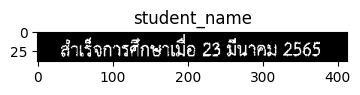

In [ ]:
indices_fh = [3, 10, 11]
indices_sh = [-3, -1]
student_name, field_of_study, field_of_work = [text_group_stud_fh_images[i] for i in indices_fh]
cgpa, graduation_date = [text_group_stud_sh_images[i] for i in indices_sh]

'''
plt.figure(figsize=(4,4))
plt.imshow(graduation_date, cmap="gray")
plt.title(f"student_name")
plt.show()
'''